# Automating Portfolio Optimization in Pytho

https://towardsdatascience.com/automating-portfolio-optimization-using-python-9f344b9380b9

In [225]:
import quantstats as qs
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import datetime as dt

import numpy as np 
# Used to grab the stock prices, with yahoo 
import pandas_datareader as web 
#from datetime import datetime 
# To visualize the results 
import matplotlib.pyplot as plt 
import seaborn
import quantstats as qs

#Importing all required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter


In [248]:
x = 25.68*114 /25.880
x

113.11901081916538

In [190]:
!pip install PyPortfolioOpt


In [226]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter
from pypfopt import discrete_allocation

Guys putting all together we have this 

Order Imbalance
- Clear buy: NVDA, BIDU, SBUX
- Clear sell: TMO, XOM, FUTU, CRWD, LMT

Fama French three factors 
- Clear Buy:"NVDA","ADBE","BIDU","FTNT","TCEHY","CSCO"
- Clear Sell: 7203.T,PEP,JNJ,IBM,TCOM,LMT,XOM

Relative Investing : 
- Clear Sell : "MU","CRWD","PANW","ZS","BEPC","PAC","BIDU"

Diversifcation :
- Remove : 'AAPL','FTNT'

We are investing in, I have used some optimiztion to reduce volatility and increase the sharpe ratio

Discrete allocation (HRP): {'BSL': 1343, 'C6L.SI': 2865, 'NEE': 189, 'DBS': 438, 'SBUX': 82, 'VBR': 44, 'CSCO': 154, 'JPM': 35, 'ADBE': 13, 'MA': 13, 'YUMC': 96, 'TCEHY': 114, 'NVDA': 20, 'BA': 12}
Funds remaining (HRP): $9.16

Expected annual return: 10.0%
Expected Annual volatility: 15.9%
Expected Sharpe Ratio: 0.50

If everyine is fine with this then i will invest tomorrow
Can give a thumbs up if you ok with it. Thanks.


In [2]:
import pandas as pd
tickers = pd.read_excel("BidAskVolume.xlsx")
tickers=list(tickers.loc[1].dropna().drop_duplicates().values)
tickers=[i.split()[0] for i in tickers]
len(tickers)
# update tickers
tickers.remove("RFMD")
tickers.append("BSL")
tickers.remove("SIA")
tickers.append("C6L.SI")
tickers.remove("7203")
tickers.append("7203.T")

In [3]:
relative_sell = ["MU","CRWD","PANW","ZS","BEPC","PAC","BIDU"]
order_sell = ["TMO", "XOM", "FUTU", "CRWD", "LMT"]
fama_sell = ["7203.T","PEP","JNJ","IBM","TCOM","LMT","XOM"]
diversification = ['AAPL', 'FTNT']
sell = fama_sell+order_sell+relative_sell+diversification

In [4]:
len(tickers)-len(set(sell))

13

In [5]:
for i in sell:
    try:
        tickers.remove(i)
    except:
        print(i)
        continue
len(tickers)

XOM
LMT
CRWD
PAC


14

In [7]:
tickers.sort()
tickers


['ADBE',
 'BA',
 'BSL',
 'C6L.SI',
 'CSCO',
 'DBS',
 'JPM',
 'MA',
 'NEE',
 'NVDA',
 'SBUX',
 'TCEHY',
 'VBR',
 'YUMC']

In [249]:
# scraping data of decided stock to invest
thelen = len(tickers)
price_data = []
for ticker in range(thelen):
    prices = web.DataReader(tickers[ticker], start='2015-01-01', end = '2022-10-25', data_source='yahoo')
    price_data.append(prices.assign(ticker=ticker)[['Adj Close']])
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.head()

#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df_stocks,columns=tickers)
print(nullin_df.isnull().sum())

NVDA       51
BA         51
CSCO       51
NEE        51
VBR        51
DBS        51
JPM        51
YUMC      503
TCEHY      51
ADBE       51
SBUX       51
MA         51
BSL        51
C6L.SI     57
dtype: int64


# MAX-Sharpe and Min_vol

In [184]:
#Annualized Return
mu = expected_returns.mean_historical_return(df_stocks)
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)

In [185]:
#Max Sharpe Ratio - Tangent to the EF
ef = EfficientFrontier(mu, Sigma, weight_bounds=(-1,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('NVDA', 1.0), ('BA', -0.47723), ('CSCO', -0.45162), ('NEE', 1.0), ('VBR', -1.0), ('DBS', 0.02598), ('JPM', 0.85429), ('YUMC', -0.05243), ('TCEHY', -0.12901), ('ADBE', -0.05477), ('SBUX', 0.06446), ('MA', 0.61241), ('BSL', 0.13482), ('C6L.SI', -0.5269)])


In [186]:
# Get portfolio performance
ef.portfolio_performance(verbose=True)  # 2 year risk free rate - Treasury Yield would set risk_free_rate=0.27

Expected annual return: 78.6%
Annual volatility: 56.4%
Sharpe Ratio: 1.36


(0.7864109076738474, 0.5636738878509548, 1.3596707674287365)

In [187]:
# Minimum Volatility Portfolio
ef2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))  # weight_bounds in negative allows shorting of stocks
minvol = ef2.min_volatility()
minvol_pwt = ef2.clean_weights()
print(minvol_pwt)

OrderedDict([('NVDA', 0.0), ('BA', 0.0), ('CSCO', 0.09687), ('NEE', 0.13541), ('VBR', 0.0), ('DBS', 0.15903), ('JPM', 0.0), ('YUMC', 0.02847), ('TCEHY', 0.00486), ('ADBE', 0.0), ('SBUX', 0.00363), ('MA', 0.0), ('BSL', 0.3658), ('C6L.SI', 0.20593)])


In [188]:
# Get MinVol portfolio performance
ef2.portfolio_performance(verbose=True)  # 2 year risk free rate - Treasury Yield would set risk_free_rate=0.27

Expected annual return: 3.0%
Annual volatility: 13.1%
Sharpe Ratio: 0.07


(0.029714650016791456, 0.13100553803786494, 0.074154498827245)

In [153]:
latest_prices = discrete_allocation.get_latest_prices(df_stocks)
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
#Min Volatility Portfolio Allocation $10000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=100000).lp_portfolio()
print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))

{'CSCO': 223, 'NEE': 185, 'DBS': 609, 'YUMC': 73, 'TCEHY': 19, 'SBUX': 4, 'BSL': 2940, 'C6L.SI': 4086}
Leftover Fund value in$ after building minimum volatility portfolio is $17.34


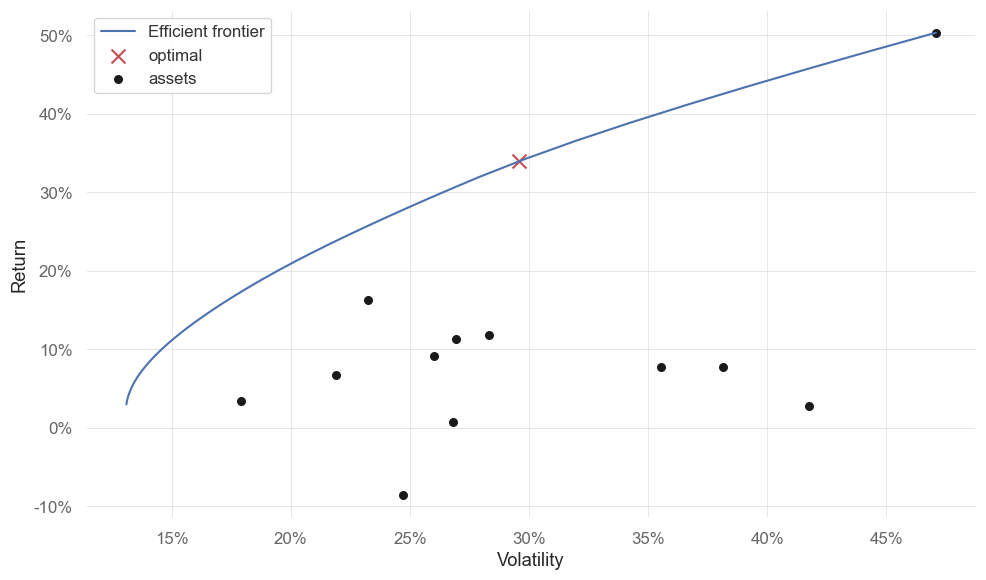

In [154]:
# Plot the Efficient Frontier for visual puposes
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.0%}".format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))

In [155]:
# Get latest prices
latest_prices = discrete_allocation.get_latest_prices(df_stocks)
latest_prices

NVDA      125.989998
BA        142.050003
CSCO       43.540001
NEE        73.279999
VBR       153.279999
DBS        26.093800
JPM       122.379997
YUMC       38.840000
TCEHY      25.680000
SBUX       83.760002
BSL        12.440000
C6L.SI      5.040000
Name: 2022-10-24 00:00:00, dtype: float64

In [156]:
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy
# Max Sharpe Ratio Portfolio Allocation $10,000
allocation_shp, rem_shp = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices, total_portfolio_value=100000).lp_portfolio(verbose=True)
print(allocation_shp)
print("Leftover fund after building Max Sharpe Portfolio is ${:.2f}".format(rem_shp))


Allocating long sub-portfolio:

Allocating short sub-portfolio:
{'NVDA': 239, 'NEE': 410, 'DBS': 53, 'JPM': 234, 'SBUX': 64, 'BSL': 358, 'BA': -282, 'CSCO': -736, 'VBR': -652, 'YUMC': -65, 'TCEHY': -410, 'C6L.SI': -9382}
Leftover fund after building Max Sharpe Portfolio is $89.76


# HRP
https://builtin.com/data-science/portfolio-optimization-python

In [250]:
from pypfopt import HRPOpt


In [251]:
returns = df_stocks.pct_change().dropna()

In [252]:
hrp = HRPOpt(returns)
hrp_weights = hrp.optimize()

In [236]:
hrp.portfolio_performance(verbose=True)
print(dict(hrp_weights))

Expected annual return: 9.9%
Annual volatility: 15.9%
Sharpe Ratio: 0.50
{'ADBE': 0.0416083731441074, 'BA': 0.017321437540238044, 'BSL': 0.1670230552748511, 'C6L.SI': 0.1444052349521648, 'CSCO': 0.06719110448096295, 'DBS': 0.11435867372893743, 'JPM': 0.042300181083950464, 'MA': 0.04006538163176601, 'NEE': 0.13806422538801777, 'NVDA': 0.025136545086770948, 'SBUX': 0.06828029702191452, 'TCEHY': 0.02934209179770717, 'VBR': 0.06785378547543765, 'YUMC': 0.03704961339317375}


In [253]:
# Get latest prices
latest_prices = discrete_allocation.get_latest_prices(df_stocks)
latest_prices['DBS']=32.760
latest_prices

NVDA      132.091003
BA        145.830002
CSCO       44.084999
NEE        75.709999
VBR       156.265793
DBS        32.760000
JPM       122.974998
YUMC       40.439999
TCEHY      25.820000
ADBE      322.415009
SBUX       84.879997
MA        308.755005
BSL        12.375000
C6L.SI      5.030000
Name: 2022-10-25 00:00:00, dtype: float64

In [254]:
da_hrp = discrete_allocation.DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da_hrp.greedy_portfolio()
print("Discrete allocation (HRP):", allocation)
print("Funds remaining (HRP): ${:.2f}".format(leftover))

Discrete allocation (HRP): {'BSL': 1351, 'C6L.SI': 2874, 'NEE': 182, 'DBS': 349, 'SBUX': 80, 'VBR': 44, 'CSCO': 152, 'JPM': 34, 'ADBE': 13, 'MA': 13, 'YUMC': 91, 'TCEHY': 113, 'NVDA': 19, 'BA': 12}
Funds remaining (HRP): $1.93


NameError: name 'allocation' is not defined

# Mean Conditional Value at Risk (mCVAR)


In [163]:
from pypfopt.efficient_frontier import EfficientCVaR


In [164]:
#Annualized Return
mu = expected_returns.mean_historical_return(df_stocks)
#Sample Variance of Portfolio
S = df_stocks.cov()
ef_cvar = EfficientCVaR(mu, S)
cvar_weights = ef_cvar.min_cvar()

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

{'NVDA': 0.0, 'BA': 0.03461, 'CSCO': 0.0, 'NEE': 0.0, 'VBR': 0.0, 'DBS': 0.38766, 'JPM': 0.0, 'YUMC': 0.0, 'TCEHY': 0.0, 'SBUX': 0.0, 'BSL': 0.0, 'C6L.SI': 0.57773}


In [165]:
da_cvar = discrete_allocation.DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

Discrete allocation (CVAR): {'C6L.SI': 11462, 'DBS': 1486, 'BA': 24, 'YUMC': 1}
Funds remaining (CVAR): $8.09


# Mean Variance Optimization


In [166]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage


mu = mean_historical_return(df_stocks)
S = CovarianceShrinkage(df_stocks).ledoit_wolf()

In [167]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'NVDA': 0.57095, 'BA': 0.0, 'CSCO': 0.0, 'NEE': 0.42905, 'VBR': 0.0, 'DBS': 0.0, 'JPM': 0.0, 'YUMC': 0.0, 'TCEHY': 0.0, 'SBUX': 0.0, 'BSL': 0.0, 'C6L.SI': 0.0}


In [168]:
ef.portfolio_performance(verbose=True)


Expected annual return: 35.7%
Annual volatility: 31.0%
Sharpe Ratio: 1.09


(0.35718891927503355, 0.3098643244797978, 1.0881824483702938)

In [169]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df_stocks)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'NVDA': 453, 'NEE': 585}
Funds remaining: $57.73


# Portfolio evaluation

In [203]:
qs.stats.volatility(df_stocks)

NVDA      0.470635
BA        0.417212
CSCO      0.259873
NEE       0.232533
VBR       0.219035
DBS       0.268183
JPM       0.283246
YUMC      0.311812
TCEHY     0.381239
ADBE      0.321696
SBUX      0.269319
MA        0.282347
BSL       0.178922
C6L.SI    0.246944
dtype: float64

In [205]:
qs.stats.expected_return(df_stocks)*252

NVDA      0.407731
BA        0.027805
CSCO      0.087235
NEE       0.150863
VBR       0.065332
DBS       0.007586
JPM       0.111608
YUMC      0.057477
TCEHY     0.074080
ADBE      0.183556
SBUX      0.106853
MA        0.164280
BSL       0.033096
C6L.SI   -0.089718
dtype: float64

In [218]:
portfolio_value=0
for i in allocation:
    portfolio_value+= df_stocks.dropna()[i]*allocation[i]